In [4]:
import numpy as np
import PIL.Image
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.grid'] = False

In [5]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
    tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [6]:
# content_path = tf.keras.utils.get_file('joker.jpg', 
#                                        'https://static3.srcdn.com/wordpress/wp-content/uploads/2019/11/The-Joker.jpg?q=50&fit=crop&w=960&h=500')
content_path = tf.keras.utils.get_file('joker_1.jpg', 'https://image.businessinsider.com/5d9b9acc49e03f38f4481121?width=1100&format=jpeg&auto=webp')

style_path = tf.keras.utils.get_file('starry_night.jpg',
                                     'https://media.overstockart.com/optimized/cache/data/product_images/VG485-1000x1000.jpg')

In [7]:
def load_img(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [8]:
def show_image(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

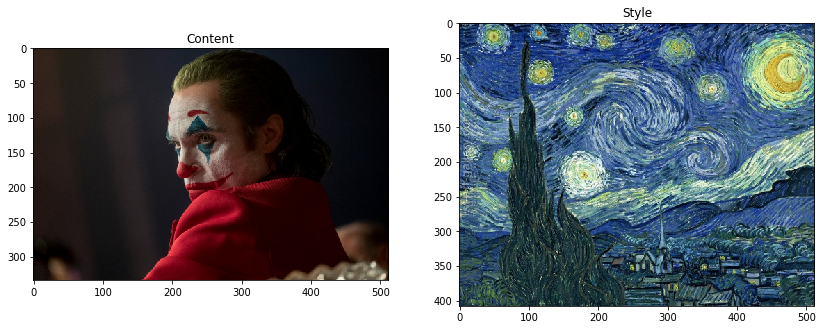

In [9]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
show_image(content_image, title='Content')

plt.subplot(1, 2, 2)
show_image(style_image, title='Style')

### Content & Style Representations using VGG19

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
pred_probs = vgg(x)
pred_probs.shape

TensorShape([1, 1000])

In [11]:
pred_top5 = tf.keras.applications.vgg19.decode_predictions(pred_probs.numpy())[0]
pred_top5

[('n03838899', 'oboe', 0.07014016),
 ('n03759954', 'microphone', 0.0627715),
 ('n03372029', 'flute', 0.05507638),
 ('n04141076', 'sax', 0.05502708),
 ('n03884397', 'panpipe', 0.041765373)]

In [12]:
## Loading a headless VGG19
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
    print(layer.name)
##
##

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [14]:
def vgg_layers(layer_names):
    """VGG Model that returns list of intermediate output values"""

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [15]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 408, 512, 64)
  min:  0.0
  max:  802.0636
  mean:  26.687359

block2_conv1
  shape:  (1, 204, 256, 128)
  min:  0.0
  max:  3496.3489
  mean:  169.10538

block3_conv1
  shape:  (1, 102, 128, 256)
  min:  0.0
  max:  9451.456
  mean:  158.80801

block4_conv1
  shape:  (1, 51, 64, 512)
  min:  0.0
  max:  14689.591
  mean:  603.5269

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3913.5251
  mean:  52.77621



### Calculating Style using a gram matrix

In [16]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

### Style & Content Extractor Model

In [17]:
class StyleContentExtractor(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        super(StyleContentExtractor, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    
    def call(self, x):
        x = x * 255.0
        preprocessed_x = tf.keras.applications.vgg19.preprocess_input(x)
        outputs = self.vgg(preprocessed_x)
        
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name: value for content_name, value in zip(self.style_layers, style_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

In [18]:
extractor = StyleContentExtractor(style_layers, content_layers)
results = extractor(tf.constant(content_image))
style_results = results['style']

### Style Transfer Algorithm (Gradient Descent)

In [19]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [20]:
image = tf.Variable(content_image)

In [21]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [22]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [23]:
style_weight = 100
content_weight = 10

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    
    loss = style_loss + content_loss
    return loss

In [25]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

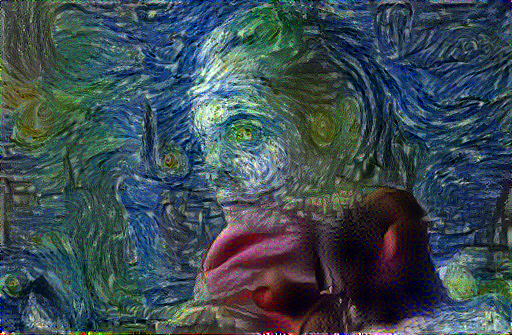

Train step: 100
Total time: 96.6


In [27]:
import time
import IPython.display as display
start = time.time()

epochs = 1
steps_per_epoch = 100

step = 0
for _ in range(epochs):
    for _ in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
print("Total time: {:.1f}".format(time.time()-start))